# Model testing

- It's just a testing ground for the model. One model is loaded and a `cmc.test_model` is applied on it.
- As a result confusion matrix, ROC, AUROC, F1, PR curves will be generated and saved to the model's folder

In [1]:
from skimage.metrics import structural_similarity as ssim
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import BinaryPrecision, BinaryRecall, F1Score
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import numpy as np
from PIL import Image
import random
import json
import time
from torchmetrics.classification import MulticlassConfusionMatrix, F1Score, MulticlassPrecision, MulticlassRecall
from PhyDNet_models import ConvLSTM,PhyCell, ClassifierRNN
from PhyDNet.data.moving_mnist import MovingMNIST
from sklearn.metrics import cohen_kappa_score, precision_score, recall_score, f1_score
from PhyDNet.constrain_moments import K2M
import torch.multiprocessing as mp

from tqdm import tqdm
import os
import re
import pandas as pd
from torchvision.io import read_image
from datetime import datetime
from pathlib import Path
import confinement_mode_classifier as cmc
from torch.utils.tensorboard import SummaryWriter

import PhyDNet_COMPASS as pdnt
mp.set_start_method('spawn')

In [2]:
batch_size=8

test_run=False
test_df_contains_val_df=True
n_frames_input=4
num_workers=8
ris_option = 'RIS1'
path = Path(os.getcwd())
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
save_name = '24-05-28, 17-30-36 phydnet, changed loss, onecycleLR'

#### Create dataloaders ########################################
shot_usage = pd.read_csv(f'{path}/data/shot_usageNEW.csv')
shot_for_ris = shot_usage[shot_usage['used_for_ris2'] if ris_option == 'RIS2' else shot_usage['used_for_ris1']]
shot_numbers = shot_for_ris['shot']
shots_for_testing = shot_for_ris[shot_for_ris['used_as'] == 'test']['shot']
shots_for_validation = shot_for_ris[shot_for_ris['used_as'] == 'val']['shot']
shots_for_training = shot_for_ris[shot_for_ris['used_as'] == 'train']['shot']

if test_df_contains_val_df:
    shots_for_testing = pd.concat([shots_for_testing, shots_for_validation])
if test_run:
    shots_for_testing = shots_for_testing[:1]
    shots_for_validation = shots_for_validation[:1]
    shots_for_training = shots_for_training[:1]

shot_df, test_df, val_df, train_df = cmc.load_and_split_dataframes(path,shot_numbers, shots_for_training, shots_for_testing, 
                                                                shots_for_validation, use_ELMS=True, ris_option='RIS1',exponential_elm_decay=True)
#Read article, see PhyDNet/constrain_moments.py
constraints = torch.zeros((49,7,7)).to(device)
ind = 0
for i in range(0,7):
    for j in range(0,7):
        constraints[ind,i,j] = 1
        ind +=1   

test_loader = pdnt.get_loader(test_df, batch_size=batch_size, num_workers=num_workers, n_frames_input=n_frames_input, path=path, balance=False)

/compass/Shared/Users/bogdanov/.venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [4]:
phycell  =  PhyCell(input_shape=(88,88), input_dim=352, F_hidden_dims=[49], n_layers=1, kernel_size=(7,7), device=device) 
convcell =  ConvLSTM(input_shape=(88,88), input_dim=352, hidden_dims=[8,352], n_layers=2, kernel_size=(3,3), device=device)   
classifier = ClassifierRNN(phycell, convcell, device)

classifier.load_state_dict(torch.load(f'PhyDNet/runs/{save_name}/model_chkpt_best_acc.pt'))
classifier.eval()

writer = SummaryWriter(f'PhyDNet/runs/{save_name}')
criterion = nn.CrossEntropyLoss()

layer  0 input dim  352  hidden dim  8
layer  1 input dim  8  hidden dim  352


Processing batches:   0%|          | 0/8087 [00:00<?, ?it/s]/compass/Shared/Users/bogdanov/.venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Processing batches: 100%|██████████| 8087/8087 [1:08:24<00:00,  1.97it/s]


Processing metrics...


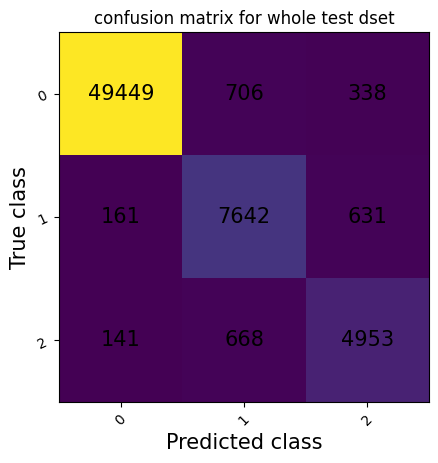

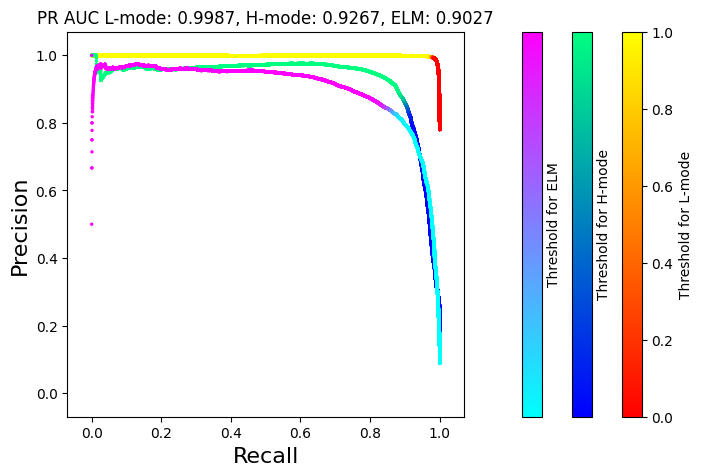

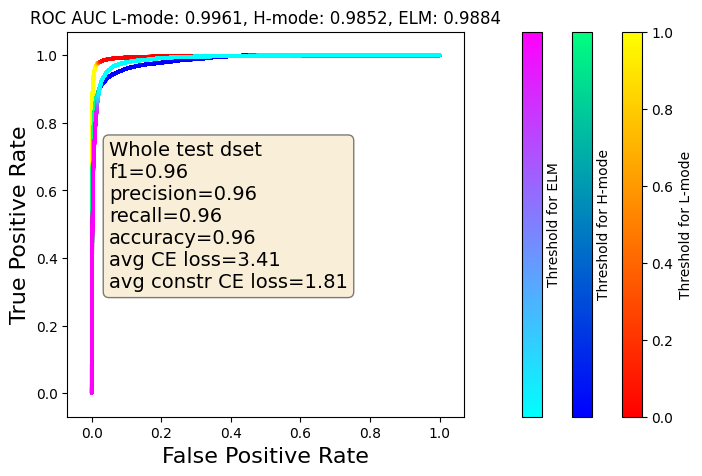

In [5]:
metrics = pdnt.test_model(f'PhyDNet/runs/{save_name}', classifier, test_loader,
                              comment='', writer=writer, signal_name='imgs_input', num_classes=3, 
                              constraints=constraints, criterion=criterion)

In [6]:
metrics

{'prediction_df':         shot prediction  label    time  prob_0        prob_1        prob_2
 0      16534          0      0   960.2     1.0  3.212367e-10  1.408136e-14
 1      16534          0      0   960.4     1.0  8.238476e-09  1.292180e-19
 2      16534          0      0   960.6     1.0  3.010462e-07  1.909397e-18
 3      16534          0      0   960.8     1.0  7.390713e-09  6.261347e-17
 4      16534          0      0   961.0     1.0  8.004473e-10  2.997484e-17
 ...      ...        ...    ...     ...     ...           ...           ...
 64684  19379          0      0  1329.0     1.0  6.714610e-22  2.600553e-20
 64685  19379          0      0  1329.2     1.0  4.098568e-21  3.340656e-19
 64686  19379          0      0  1329.4     1.0  8.874771e-22  2.083252e-20
 64687  19379          0      0  1329.6     1.0  5.940631e-21  3.387559e-19
 64688  19379  tensor(0)      0  1329.8     1.0  2.721812e-21  6.413196e-20
 
 [64689 rows x 7 columns],
 'confusion_matrix': (<Figure size 640x480

In [7]:
metrics['prediction_df'].to_csv(f'PhyDNet/runs/{save_name}/prediction_df.csv')

In [8]:
results_df = pd.read_csv(f'PhyDNet/runs/{save_name}/prediction_df.csv', index_col=0)

In [9]:
metrics['prediction_df'].to_csv(f'PhyDNet/runs/{save_name}/prediction_df.csv')

metrics_per_shot = cmc.per_shot_test(path=f'PhyDNet/runs/{save_name}', 
                        shots=shots_for_testing.values.tolist(), results_df=metrics['prediction_df'],
                        writer=writer, num_classes=3,
                        two_images=False)

metrics_per_shot = pd.DataFrame(metrics_per_shot)
metrics_per_shot.to_csv(f'PhyDNet/runs/{save_name}/metrics_per_shot.csv')

  6%|▋         | 2/32 [00:00<00:10,  2.99it/s]/compass/Shared/Users/bogdanov/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
 31%|███▏      | 10/32 [00:03<00:07,  2.85it/s]/compass/Shared/Users/bogdanov/.venv/lib/python3.8/site-packages/torchmetrics/utilities/plot.py:245: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(nrows=rows, ncols=cols) if ax is None else (ax.get_figure(), ax)
 50%|█████     | 16/32 [00:05<00:06,  2.54it/s]/compass/Shared/Users/bogdanov/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:697: RuntimeWarning: invalid val

In [10]:
metrics

{'prediction_df':         shot prediction  label    time  prob_0        prob_1        prob_2
 0      16534          0      0   960.2     1.0  3.212367e-10  1.408136e-14
 1      16534          0      0   960.4     1.0  8.238476e-09  1.292180e-19
 2      16534          0      0   960.6     1.0  3.010462e-07  1.909397e-18
 3      16534          0      0   960.8     1.0  7.390713e-09  6.261347e-17
 4      16534          0      0   961.0     1.0  8.004473e-10  2.997484e-17
 ...      ...        ...    ...     ...     ...           ...           ...
 64684  19379          0      0  1329.0     1.0  6.714610e-22  2.600553e-20
 64685  19379          0      0  1329.2     1.0  4.098568e-21  3.340656e-19
 64686  19379          0      0  1329.4     1.0  8.874771e-22  2.083252e-20
 64687  19379          0      0  1329.6     1.0  5.940631e-21  3.387559e-19
 64688  19379  tensor(0)      0  1329.8     1.0  2.721812e-21  6.413196e-20
 
 [64689 rows x 7 columns],
 'confusion_matrix': (<Figure size 640x480

In [11]:
tensor_probs = torch.tensor(metrics['prediction_df'][['prob_0', 'prob_1', 'prob_2']].values).to(device)
tensor_probs = torch.softmax(tensor_probs, dim=1)

metrics['prediction_df'][['prob_0', 'prob_1', 'prob_2']] = tensor_probs.cpu().numpy()

In [12]:
metrics['prediction_df'].to_csv(f'PhyDNet/runs/{save_name}/prediction_df.csv')